## Prepare Transformers and Emotions Data

In [1]:
import pandas as pd

In [2]:
# read in data
from google.colab import drive
drive.mount('/content/drive')
comments_df = pd.read_csv("drive/MyDrive/Colab Notebooks/comments.csv.xls")

Mounted at /content/drive


In [3]:
!pip install transformers
!pip install datasets
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import transformers
import datasets
import shap
import json

# load the emotion dataset
dataset  = datasets.load_dataset("emotion", split = "train")
data = pd.DataFrame({'text':dataset['text'],'emotion':dataset['label']})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


In [5]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [6]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

# for each text, get the average scores for each emotion
comments_scores = {
    'sadness': [],
    'joy': [],
    'love': [],
    'anger': [],
    'fear': [],
    'surprise': []
                  }
for doc in comments_df['comment_text']:
  if doc is not None:
    emo_dicts = pred(str(doc))[0]
    for i in emo_dicts:
      comments_scores[i['label']].append(i['score'])

# print means for each emotion for momlife
for key, val in comments_scores.items():
  avg = sum(val) / len(val)
  print(key + ": " + str(avg))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


sadness: 0.06201454469989867
joy: 0.5350227568837225
love: 0.13221296717580272
anger: 0.21284843972214104
fear: 0.039505459891794735
surprise: 0.018395831884856186


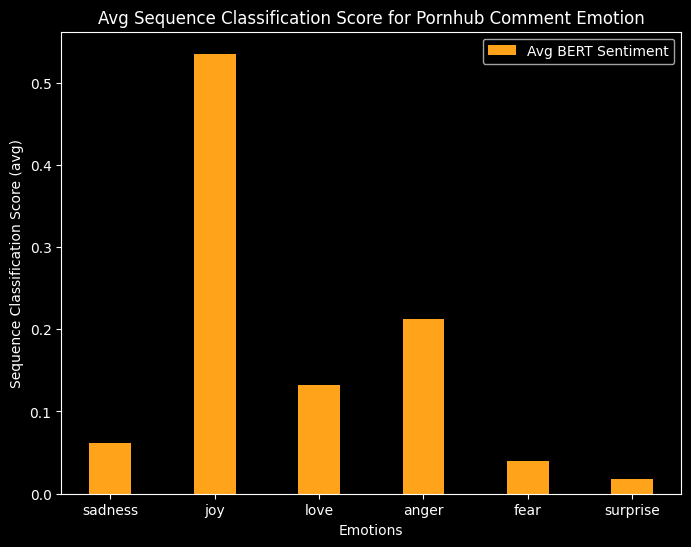

In [8]:
sent_dict = {
    'sadness': 0.06201454469989867,
    'joy': 0.5350227568837225,
    'love': 0.13221296717580272,
    'anger': 0.21284843972214104,
    'fear': 0.039505459891794735,
    'surprise': 0.018395831884856186
}

import matplotlib.pyplot as plt

X = list(sent_dict.keys())
emo_val = sent_dict.values()
  
X_axis = np.arange(len(X))
  
fig = plt.figure() 
fig.set_size_inches(8, 6)
plt.style.use('dark_background')
plt.bar(X_axis, emo_val, 0.4, label = 'Avg BERT Sentiment', color='#ffa31a')
  
plt.xticks(X_axis, X)
plt.xlabel("Emotions", color='white')
plt.ylabel("Sequence Classification Score (avg)", color='white')
plt.title("Avg Sequence Classification Score for Pornhub Comment Emotion", color='white')
plt.legend()
plt.show()

In [9]:
comments_df['sadness'] = comments_scores['sadness']
comments_df['joy'] = comments_scores['joy']
comments_df['love'] = comments_scores['love']
comments_df['anger'] = comments_scores['anger']
comments_df['surprise'] = comments_scores['surprise']

In [10]:
comments_df

,username_href,view_key,comment_text,upvotes,timestamp,sadness,joy,love,anger,surprise
0,/users/karmenbela,ph5b7b35bb1a9e8,Old video...come on pornhub...you can do bette...,6,0000-00-00 00:00:00,0.039150,0.911864,0.008323,0.030093,0.004316
1,/model/amy-plydale,ph5df6a59039b5b,Wow 😍,0,0000-00-00 00:00:00,0.034792,0.793039,0.049078,0.054680,0.043277
2,/users/angelamp26,ph5b7b35bb1a9e8,Does anyone know what is the IG account from t...,2,0000-00-00 00:00:00,0.043733,0.192145,0.010613,0.478970,0.015940
3,/users/chloefxxx,ph5b7b35bb1a9e8,Clickbait in porn... I just totally lost my fa...,1,0000-00-00 00:00:00,0.920732,0.029093,0.002300,0.022475,0.001933
4,/pornstar/skyla-pink,ph61e3425a59722,I would definitely suck a fart out of your ass...,1,0000-00-00 00:00:00,0.004646,0.027487,0.007851,0.952511,0.003504
...,...,...,...,...,...,...,...,...,...,...
838715,/users/pornob,752431918,Good esta chicas estan hot bien perras,3,0000-00-00 00:00:00,0.005348,0.436040,0.538402,0.014999,0.003807
838716,/users/dextershark,752431918,Amazing but want full video,2,0000-00-00 00:00:00,0.007033,0.373413,0.021319,0.013529,0.564870
838717,/users/shemaleplz3,ph6220a2e5df79b,Yes spread her & shove it in deep!! Open that ...,0,0000-00-00 00:00:00,0.016007,0.836237,0.033697,0.099151,0.003239
838718,/users/awesomelover1,ph6220a2e5df79b,I love this video my favorite part is where sh...,0,0000-00-00 00:00:00,0.020746,0.133354,0.678686,0.160411,0.004698


In [11]:
comments_df.to_csv("drive/MyDrive/Colab Notebooks/comments_with_BERTsent.csv")